In [45]:
# Tratamiento de datos
import numpy as np
import pandas as pd
import snscrape.modules.twitter as sntwitter
import re, string, warnings


# Graficacion
from matplotlib import style
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento y modelado
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.spatial.distance import cosine

#stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Ignorar warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /home/cruv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [124]:
def formateo_texto(text):
    
    # Texto a minúsculas
    new_text = text.lower()
    # Eliminación de páginas web
    new_text = re.sub('http\S+', ' ', new_text)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    new_text = re.sub(regex , ' ', new_text)
    # Eliminación de números
    new_text = re.sub("\d+", ' ', new_text)
    # Eliminación de espacios en blanco múltiples
    new_text = re.sub("\\s+", ' ', new_text)
    # Tokenización por palabras individuales
    new_text = new_text.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    new_text = [token for token in new_text if len(token) > 1]
    
    return(new_text)


def sentimientos(df):
    print(autor,"\n")
    print(f"Positivos: {round(100 * np.mean(df.sentimiento > 0), 2)}")
    print(f"Neutros  : {round(100 * np.mean(df.sentimiento == 0), 2)}")
    print(f"Negativos: {round(100 * np.mean(df.sentimiento < 0), 2)}\n")

def similitud_coseno(a,b):
    return 1-cosine(a,b)

## Extraccion de datos.
Extraccion de Tweets realizados por Barack Obama, Joe Biden y Zendaya topado a 1,200 tweets.

In [89]:
%%time

# Parámetros
tweets_list = []
max_tweets = 1200


users_name = ['BarackObama','JoeBiden','Zendaya']

for n, k in enumerate(users_name):
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper('from:{}'.format(users_name[n])).get_items()):
            if i>max_tweets-1:
                break
            tweets_list.append([tweet.user.username, tweet.date, tweet.id, tweet.content])

CPU times: user 2.85 s, sys: 74.2 ms, total: 2.93 s
Wall time: 1min 19s


Al momento de realizar la extraccion de los datos, estos se hacen en forma de lista. Por lo que vamos a transformar la data extraida en un Data frame para darle un formato mas manejables para las librerias que utilizaremos.

In [90]:
df_tweets = pd.DataFrame (tweets_list,columns = ['autor', 'fecha', 'id', 'texto'])
df_tweets['fecha'] = pd.to_datetime(df_tweets['fecha'])
df_tweets.head()

,autor,fecha,id,texto
0,BarackObama,2022-11-29 17:01:00+00:00,1597636758505934848,Michelle and I started the @ObamaFoundation to...
1,BarackObama,2022-11-26 16:31:21+00:00,1596542133925658624,"Last month, I spoke with some of the incredibl..."
2,BarackObama,2022-11-24 14:59:12+00:00,1595794166830682112,One of my favorite White House traditions was ...
3,BarackObama,2022-11-24 13:30:27+00:00,1595771830878576642,Wishing everyone a happy Thanksgiving! As we c...
4,BarackObama,2022-11-23 20:00:49+00:00,1595507681749569559,"But voters in some states—including Florida, T..."


Verificaremos que los Tweets extraidos de cada usuario sean los 2,000 que solicitamos anteriormente.

In [91]:
print('Número de tweets @Barack Obama: ', len(df_tweets[df_tweets['autor']=='BarackObama']))
print('Número de tweets @Joe Biden: ', len(df_tweets[df_tweets['autor']=='JoeBiden']))
print('Número de tweets @Zendaya: ', len(df_tweets[df_tweets['autor']=='Zendaya']))

Número de tweets @Barack Obama:  1200
Número de tweets @Joe Biden:  1200
Número de tweets @Zendaya:  1200


A continuacion se graficara la tendencia de numeros de tweets publicados a traves del tiempo de los tres usuarios en conjunto.

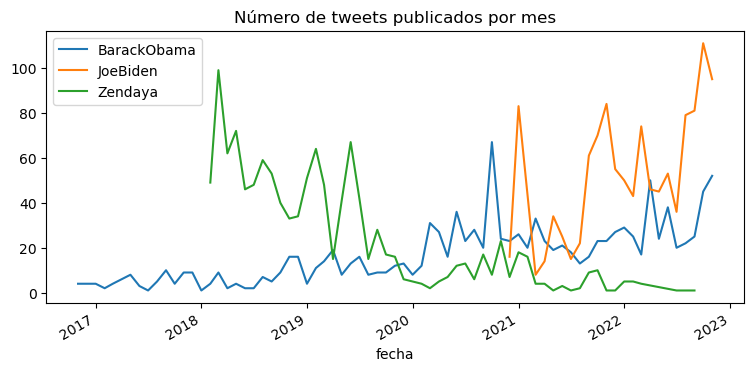

In [92]:
fig, ax = plt.subplots(figsize=(9,4))

for autor in df_tweets.autor.unique():
    df_temp = df_tweets[df_tweets['autor'] == autor].copy()
    df_temp['fecha'] = pd.to_datetime(df_temp['fecha'].dt.strftime('%Y-%m'))
    df_temp = df_temp.groupby(df_temp['fecha']).size()
    df_temp.plot(label=autor, ax=ax)

ax.set_title('Número de tweets publicados por mes')
ax.legend();

## Limpieza de datos
A consiguiente se formateara el texto extraido de cada uno de los tweets para eliminar caracteres especiales como "@", "," o incluso paginas web que puedan alterar nuestro analisis.

In [93]:
df_tweets['texto_formateado'] = df_tweets['texto'].apply(lambda x: formateo_texto(x))
df_tweets[['texto', 'texto_formateado']].head()

,texto,texto_formateado
0,Michelle and I started the @ObamaFoundation to...,"[michelle, and, started, the, obamafoundation,..."
1,"Last month, I spoke with some of the incredibl...","[last, month, spoke, with, some, of, the, incr..."
2,One of my favorite White House traditions was ...,"[one, of, my, favorite, white, house, traditio..."
3,Wishing everyone a happy Thanksgiving! As we c...,"[wishing, everyone, happy, thanksgiving, as, w..."
4,"But voters in some states—including Florida, T...","[but, voters, in, some, states—including, flor..."


## Analisis exploratorio
Se utilizara un metodo de expansion o Unnest el cual consiste en expandir la tabla que tenemos utilizando como token. cada una de las palabras utilizadas dentro de los tweets publicados por cada uno de los usuarios, en resumen haciendo cada palabra una nueva fila que se puede identificar del tweet que se extrajo utilizando el id del tweet.

In [95]:
# Unnest de la columna texto_tokenizado
tweets_tidy = df_tweets.explode(column='texto_formateado')
tweets_tidy = tweets_tidy.drop(columns='texto')
tweets_tidy = tweets_tidy.rename(columns={'texto_formateado':'token'})
tweets_tidy.head()

,autor,fecha,id,token
0,BarackObama,2022-11-29 17:01:00+00:00,1597636758505934848,michelle
0,BarackObama,2022-11-29 17:01:00+00:00,1597636758505934848,and
0,BarackObama,2022-11-29 17:01:00+00:00,1597636758505934848,started
0,BarackObama,2022-11-29 17:01:00+00:00,1597636758505934848,the
0,BarackObama,2022-11-29 17:01:00+00:00,1597636758505934848,obamafoundation


Ahora visualizaremos el numero total de palabras unicas utilizadas por cada una de las personas analizadas.

In [96]:
print('Palabras distintas por autor')
tweets_tidy.groupby(by='autor')['token'].nunique()

Palabras distintas por autor


autor
BarackObama    4894
JoeBiden       3568
Zendaya        2433
Name: token, dtype: int64

Adicional a esto, utilizaremos la estadistica para ver el numero promedio de palabras utilizadas por tweet y cual es la desviacion estandar de este numero de palabras.

In [97]:
temp_df = pd.DataFrame(tweets_tidy.groupby(by = ["autor", "id"])["token"].count())
temp_df.reset_index().groupby("autor")["token"].agg(['mean', 'std'])

,mean,std
autor,,
BarackObama,34.634167,10.339137
JoeBiden,30.055000,12.116145
Zendaya,7.869167,8.549247


De lo extraido podemos observar que Barack Obama es la persona que utiliza mas palabras en promedio de sus Tweets, con un total de 34.63 palabras por tweet, mientras que Zendaya difiere mucho de esto teniendo un promedio de 7.87 palabras por tweets, con una desviacion estandar mucho menor que cualquiera de las otras personas.<br><br>
De estas palabras extraidas con anterioridad se eliminara las stopwords que estan afectando nuestro analisis, con ayuda de la libreria nltk y agregando otras tres palabras utilizadas para letras como &, se eliminara de nuestro dataframe las palabras que estorban

In [99]:
stop_words = list(stopwords.words('english'))
stop_words.extend(("amp", "xa", "xe"))

tweets_tidy = tweets_tidy[~(tweets_tidy["token"].isin(stop_words))]

Con la extraccion de las Stepwords, analizaremos las 10 palabras mas utilizadas de cada uno de los 3 personajes.

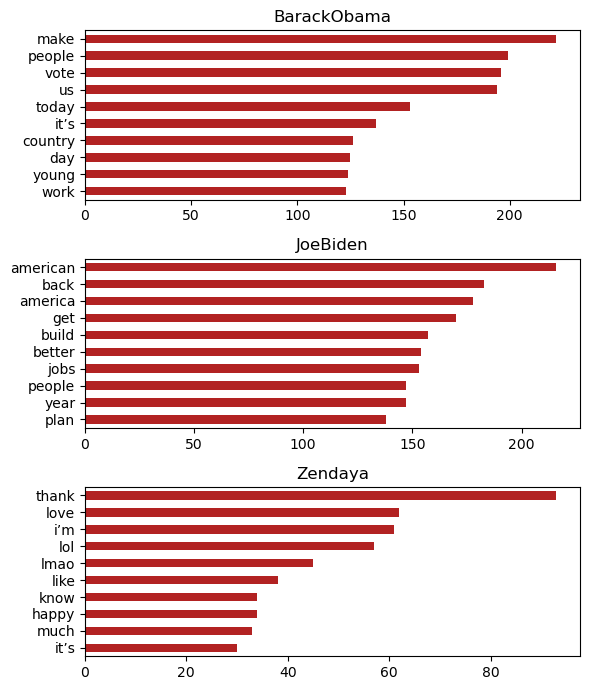

In [100]:
# Top 10 palabras por autor

fig, axs = plt.subplots(nrows=3, ncols=1,figsize=(6, 7))
for i, autor in enumerate(tweets_tidy.autor.unique()):
    df_temp = tweets_tidy[tweets_tidy.autor == autor]
    counts  = df_temp['token'].value_counts(ascending=False).head(10)
    counts.plot(kind='barh', color='firebrick', ax=axs[i])
    axs[i].invert_yaxis()
    axs[i].set_title(autor)

fig.tight_layout()

Con ayuda de la programacion, nos daremos a la tarea de ver la correlacion que tienen los tweets de cada una de las cuentas, viendo que tan parecido puede ser la cuenta de Barack Obama con la de Zendaya,

In [101]:
# Pivotado de datos
tweets_pivot = tweets_tidy.groupby(["autor","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="autor", values= "count")
tweets_pivot.columns.name = None


tweets_pivot.corr(method=similitud_coseno)

,BarackObama,JoeBiden,Zendaya
BarackObama,1.000000,0.702410,0.558341
JoeBiden,0.702410,1.000000,0.450036
Zendaya,0.558341,0.450036,1.000000


Como se podia intuir con anterioridad, la cuenta de Joe Biden, el presidente de los Estados Unidos de America, con la de Barack Obama, ex presidente de los Estados Unidos de America, se puede observar una mayor correlacion llegando a una correlacion de 0.7, mientras que ambas en contraste con la de Zendaya, la correlacion no llega mas alla del 0.56.<br><br>
Adicional al grafico se hara un analisis de las palabras en comun que tiene cada uno de los analizados entre si.

In [105]:
palabras_barack = set(tweets_tidy[tweets_tidy.autor == 'BarackObama']['token'])
palabras_joe = set(tweets_tidy[tweets_tidy.autor == 'JoeBiden']['token'])
palabras_zendaya = set(tweets_tidy[tweets_tidy.autor == 'Zendaya']['token'])

print("Palabras comunes entre Barack Obama y Joe Biden:",len(palabras_barack.intersection(palabras_joe)))
print(f"Palabras comunes entre Barack Obama y Zendaya:",len(palabras_barack.intersection(palabras_zendaya)))
print(f"Palabras comunes entre Joe Biden y Zendaya:",len(palabras_joe.intersection(palabras_zendaya)))

Palabras comunes entre Barack Obama y Joe Biden: 1934
Palabras comunes entre Barack Obama y Zendaya: 845
Palabras comunes entre Joe Biden y Zendaya: 677


Como medida adicional del analisis, se tomara la diferencia logistica de las probabilidades de palabras de los Tweets de Joe Biden y Barack Obama, para ver que palabras difieren entra ambos y ver que los hace unicos a pesar de ser similares. Y agregaremos un grafico para ver las 15 palabras que los diferencian mas.

In [106]:
# Pivotaje y despivotaje
tweets_pivot = tweets_tidy.groupby(["autor","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="autor", values= "count")

tweets_pivot = tweets_pivot.fillna(value=0)
tweets_pivot.columns.name = None

tweets_unpivot = tweets_pivot.melt(value_name='n', var_name='autor', ignore_index=False)
tweets_unpivot = tweets_unpivot.reset_index()

tweets_unpivot = tweets_unpivot[tweets_unpivot.autor.isin(['BarackObama', 'JoeBiden'])]

tweets_unpivot = tweets_unpivot.merge(
                    tweets_tidy.groupby('autor')['token'].count().rename('N'),
                    how = 'left',
                    on  = 'autor'
                 )

tweets_logOdds = tweets_unpivot.copy()
tweets_logOdds['odds'] = (tweets_logOdds.n + 1) / (tweets_logOdds.N + 1)
tweets_logOdds = tweets_logOdds[['token', 'autor', 'odds']] \
                    .pivot(index='token', columns='autor', values='odds')
tweets_logOdds.columns.name = None

tweets_logOdds['log_odds']     = np.log(tweets_logOdds.BarackObama/tweets_logOdds.JoeBiden)
tweets_logOdds['abs_log_odds'] = np.abs(tweets_logOdds.log_odds)

tweets_logOdds['autor_frecuente'] = np.where(tweets_logOdds.log_odds > 0,
                                              "BarackObama",
                                              "JoeBiden")

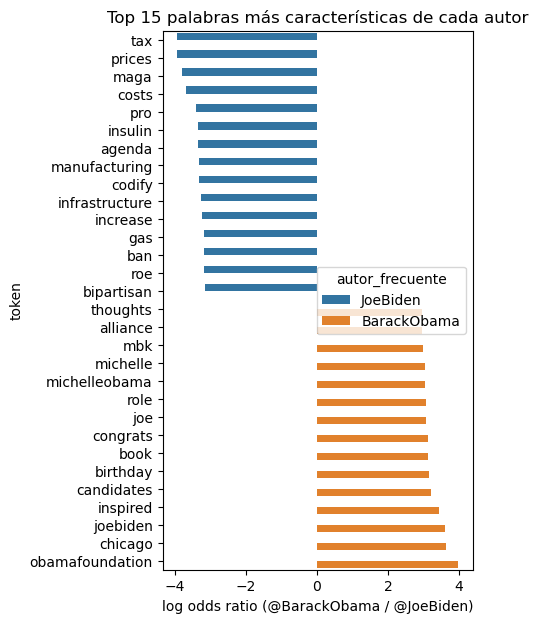

In [109]:
top_30 = tweets_logOdds[['log_odds', 'abs_log_odds', 'autor_frecuente']] \
        .groupby('autor_frecuente') \
        .apply(lambda x: x.nlargest(15, columns='abs_log_odds').reset_index()) \
        .reset_index(drop=True) \
        .sort_values('log_odds')

f, ax = plt.subplots(figsize=(4, 7))
sns.barplot(
    x    = 'log_odds',
    y    = 'token',
    hue  = 'autor_frecuente',
    data = top_30,
    ax   = ax
)
ax.set_title('Top 15 palabras más características de cada autor')
ax.set_xlabel('log odds ratio (@BarackObama / @JoeBiden)');

Podemos ver que mientras Biden, al ser presidente publica palabras mas cercana a precios e impuestos, Obama hace enfasis en su fundacion Obama Foundation y la ciudad de Chicago.<br><br>
## Analisis de sentimiento.
Utilizando el data set popular y facil de usar AFINN Lexicon, realizaremos un analisis de sentimiento con el cual nos soportara a darle un peso a cada una de las palabras que tiene cada uno de los tres usuarios.


In [110]:
lexicon = pd.read_table(
            'https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt',
            names = ['termino', 'sentimiento']
          )
lexicon.head()

,termino,sentimiento
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


Con el Dataframe extraido del data set antes mencionado, se creara uno nuevo donde se reemplazara la palabra utilizada por cada uno de los autores, y se dara como remplazo el peso de sentimiento que tiene cada palabra.

In [111]:
tweets_sentimientos = pd.merge(left = tweets_tidy,
                               right = lexicon,
                               left_on = "token",
                               right_on = "termino",
                               how = "inner")

tweets_sentimientos = tweets_sentimientos.drop(columns = "termino")

tweets_sentimientos = tweets_sentimientos[["autor","fecha", "id", "sentimiento"]] \
                      .groupby(["autor", "fecha", "id"])\
                      .sum().reset_index()
tweets_sentimientos.head()

,autor,fecha,id,sentimiento
0,BarackObama,2016-11-04 18:25:16+00:00,794606453197774849,2
1,BarackObama,2016-11-04 22:16:14+00:00,794664579834015745,4
2,BarackObama,2016-11-05 15:38:53+00:00,794926969829920768,4
3,BarackObama,2017-01-10 23:44:14+00:00,818966711995088896,2
4,BarackObama,2017-01-20 21:05:04+00:00,822550536469803009,2


De estas peso agregado para cada uno de los tweets, sacaremos el porcentaje de sentimientos de cada uno de los tres personajes, dividiendo los sentimientos en Positivo, Neutro y Negativo.

In [125]:
for autor, df in tweets_sentimientos.groupby("autor"):
    sentimientos(df)

BarackObama 

Positivos: 82.21
Neutros  : 4.63
Negativos: 13.17

JoeBiden 

Positivos: 72.71
Neutros  : 4.38
Negativos: 22.91

Zendaya 

Positivos: 78.16
Neutros  : 2.71
Negativos: 19.13



Podemos ver que Barack Obama es el mas positivo de las tres celebridades, con un total de 82.21 de palabras positivas. Mientras que Joe Biden es el mas negativo de ellos con un 22.91%.<br><br>
Ya por ultimo veremos el promedio de sentimiento que cada uno de estos tres personajes tuvo a traves del tiempo.

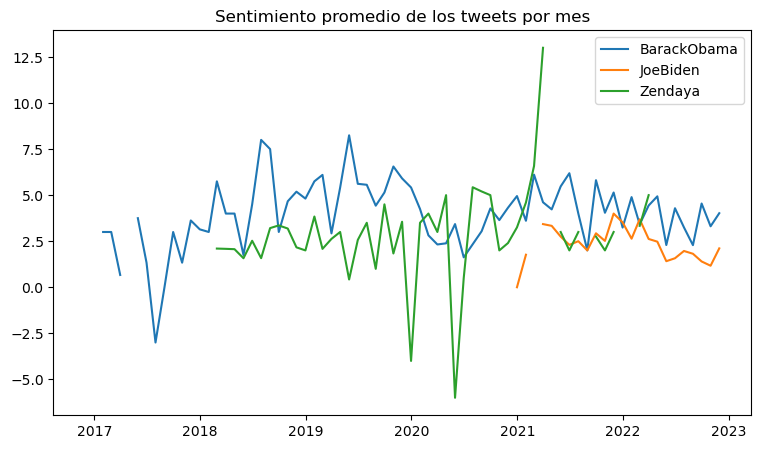

In [126]:
fig, ax = plt.subplots(figsize=(9, 5)) 

for autor in tweets_sentimientos.autor.unique():
    df = tweets_sentimientos[tweets_sentimientos.autor == autor].copy()
    df = df.set_index("fecha")
    df = df[['sentimiento']].resample('1M').mean()
    ax.plot(df.index, df.sentimiento, label=autor)

ax.set_title("Sentimiento promedio de los tweets por mes")
ax.legend();

Podemos observar que Barack Obama tuvo valores menores a 0 a mediados de 2017, lo cual representa que tuvo un periodo negativo en esa epoca, sin embargo vemos como se levanto y no ha vuelto a tener esa tendencia.<br><br>
Mientras que Zendaya por su parte tuvo varios sentimientos negativos a inicios de 2020 y mediados del mismo año, quizas viendose afectada por la pandemia vista en ese periodo.